## Imports

In [1]:
from ragas.testset import TestsetGenerator

import os
import openai

from openai import OpenAI

client = OpenAI()

/opt/anaconda3/envs/ragas/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from llama_index import download_loader, SimpleDirectoryReader


In [3]:
import matplotlib.pyplot as plt

## Assessing current state of test date generation

In [63]:
!pwd

/Users/shahules/belar/experimental


In [27]:

ArxivReader = download_loader("ArxivReader")

loader = ArxivReader() #uses simpledirectory reader under the hood, hence need modification to laod pages properly

In [31]:
# documents = loader.load_data("retrieval augmented generation AND large language model",max_results=20,papers_dir='./arxiv-papers')

In [13]:
reader = SimpleDirectoryReader("./arxiv-papers/",num_files_limit=25)
documents = reader.load_data()

## SimpleDirectoryReader?

In [5]:
len(documents)

131

In [6]:
# print(documents[14].get_metadata_str())
# print("CONTENT")
# print(documents[14].get_content())
# print(len(documents[14].get_content().split(' ')))

(array([ 5.,  3.,  6., 13., 28., 21., 39., 10.,  5.,  1.]),
 array([  10. ,  113.1,  216.2,  319.3,  422.4,  525.5,  628.6,  731.7,
         834.8,  937.9, 1041. ]),
 <BarContainer object of 10 artists>)

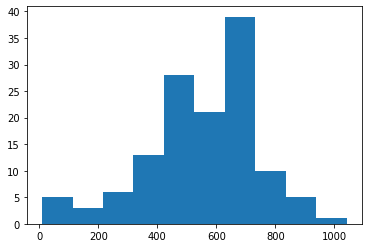

In [7]:
plt.hist([len(doc.get_content().split()) for doc in documents])

In [14]:
test_dist =  {
    "simple": 0.3,
    "reasoning": 0.25,
    "multi_context": .2,
    "conditional": 0.25,
}

In [15]:
testsetgenerator = TestsetGenerator.from_default(testset_distribution=test_dist,chunk_size=1024)


In [10]:
!pwd

/Users/shahules/belar/experimental


In [16]:
test_df = testsetgenerator.generate(documents,test_size=30)

  0%|                                                                                          | 0/30 [00:00<?, ?it/s]

Len of text chunks 2 644
Len of text chunks 4 998
Len of text chunks 2 767
Len of text chunks 3 957
seed question What is an example of a situation where you have to delegate tasks?
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


  3%|██▋                                                                               | 1/30 [00:35<17:21, 35.93s/it]

Len of text chunks 3 704
seed question What is the accuracy of I TER-RETGEN compared to DSP in multi-hop question answering?
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


 10%|████████▏                                                                         | 3/30 [01:21<11:50, 26.32s/it]

Len of text chunks 2 757
seed question What is the most common positive score and negative score given by the user in their past reviews?
{'reason': "The question mentions 'the user' which is not specified, making it unclear without extra information", 'verdict': 'No'}
rewritten question What is the most common positive score and negative score given by the user in their past reviews according to the results and discussion in the study?
{'reason': "The question mentions a 'study' in it which makes it unclear without it", 'verdict': 'No'}
Len of text chunks 3 965
seed question What is the number of train samples in the QReCC dataset for Conversational Search?
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


 20%|████████████████▍                                                                 | 6/30 [01:54<06:44, 16.84s/it]

Len of text chunks 3 698
seed question What is the impact of combining language models and imperfect retrievers on the performance of retriever-then-read models?
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


 33%|███████████████████████████                                                      | 10/30 [02:45<04:52, 14.65s/it]

Len of text chunks 2 455
seed question How many generations were sampled for the evaluation of text fluency and coherence?
{'reason': "The question mentions an 'evaluation' but doesn't specify which one, making it unclear without additional context", 'verdict': 'No'}
rewritten question How many generations were sampled for the evaluation of text fluency and coherence in the study?
{'reason': "The question mentions 'the study' but doesn't specify which one, making it unclear without it", 'verdict': 'No'}
Len of text chunks 4 980
seed question What is the purpose of the SELF-RAG framework?
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


 50%|████████████████████████████████████████▌                                        | 15/30 [03:26<02:52, 11.52s/it]

Len of text chunks 3 580
seed question What is the average improvement in performance on the TopiOCQA dataset when using the Vicuna generator with different retrievers?
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


 70%|████████████████████████████████████████████████████████▋                        | 21/30 [03:51<01:13,  8.14s/it]

Len of text chunks 2 616
Len of text chunks 2 728
Len of text chunks 2 724
Len of text chunks 3 1018
seed question Which film came out first, Blind Shaft or The Mask Of Fu Manchu?
{'reason': 'The question is clear', 'verdict': 'Yes'}


 93%|███████████████████████████████████████████████████████████████████████████▌     | 28/30 [04:10<00:11,  5.77s/it]

Len of text chunks 2 615
seed question What is the purpose of the CORE framework?
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


36it [04:25,  4.19s/it]                                                                                               

Len of text chunks 1 556
seed question What is the proposed framework in this research paper?
{'reason': "The question mentions a 'research paper' in it which makes it unclear without it", 'verdict': 'No'}
rewritten question What is the proposed framework in the research paper RETRIEVAL-GENERATION SYNERGY AUGMENTED LARGE LANGUAGE MODELS?
{'reason': 'The question mentions a specific research paper and its focus, which makes it clear without extra information', 'verdict': 'Yes'}
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


45it [05:02,  4.14s/it]

Len of text chunks 3 766
seed question Did Spiderman fight against Falcon in the MCU?
Answer: No, Spiderman did not fight against Falcon in the MCU.
{'reason': 'The question is clear', 'verdict': 'Yes'}
{'reason': 'The question is clear', 'verdict': 'Yes'}


55it [05:23,  3.34s/it]

Len of text chunks 1 545
seed question What is the impact of using Hindi retrieval data on the model's ability to retrieve "Neutral" content in the mBERT model?
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


66it [05:39,  2.65s/it]

Len of text chunks 2 668
seed question What is the Personalized Accuracy of the GPT-3.5 Summ. model for Task LaMP-1 with k=1?
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


78it [06:26,  3.11s/it]

Len of text chunks 3 835
Len of text chunks 4 1004
Len of text chunks 2 533
Len of text chunks 4 958
Len of text chunks 3 785
seed question What is the architecture of the backbone LM used in the RETRO model?
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


91it [07:15,  3.34s/it]

Len of text chunks 1 481
seed question What is the proposed method for large-scale retrieval in zero-shot scenarios?
{'reason': "The question mentions a 'proposed method' but doesn't specify where it's proposed from", 'verdict': 'No'}
rewritten question What is the proposed method for large-scale retrieval in zero-shot scenarios in the paper "Large Language Models are Strong Zero-Shot Retriever" by Tao Shen, Guodong Long, Xiubo Geng, Chongyang Tao, Tianyi Zhou, and Daxin Jiang?
{'reason': 'The question is clear', 'verdict': 'Yes'}
{'reason': "The question mentions a specific 'paper' and its content, which makes it unclear without it", 'verdict': 'No'}
Len of text chunks 3 906
seed question What was the accuracy of ChatGPT in noise robustness under a noise ratio of 0.6?
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


105it [08:08,  3.51s/it]

Len of text chunks 1 606
seed question What is the purpose of the fact checking module in RETA-LLM?
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


120it [08:31,  2.81s/it]

Len of text chunks 3 817
seed question What is the purpose of the study mentioned in the given context?
{'reason': "The question refers to a 'given context' which is not provided", 'verdict': 'No'}
rewritten question What is the purpose of the study mentioned in the given context?
{'reason': "The question refers to a 'given context' which is not provided", 'verdict': 'No'}
Len of text chunks 2 705
seed question What is the number of test samples in the QReCC dataset?
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


136it [09:01,  2.47s/it]

Len of text chunks 3 1015
seed question What is the effect of presence or absence of evidence and/or dialog history on the value of the tradeoff?
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


153it [09:10,  1.81s/it]

Len of text chunks 2 782
Len of text chunks 3 915
seed question What is the toxicity probability for RETRO (top-N= 2, top-K= 2) Pretraining in the Full set of prompts?
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': "The question mentions 'experimental results' but doesn't specify which experiment it's referring to", 'verdict': 'No'}
Len of text chunks 1 555
seed question What is the proposed framework for enhancing the performance of small language models on edge devices?
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


171it [10:31,  2.74s/it]

Len of text chunks 2 843
seed question What are the limitations of LLMs in terms of summarizing information from multiple documents?
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


190it [10:41,  1.98s/it]

Len of text chunks 4 865
Len of text chunks 2 879
seed question What are the different aspects of Carlos Moedas' biography, early life, and political career?
{'reason': 'The question is clear', 'verdict': 'Yes'}
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


210it [11:07,  1.75s/it]

Len of text chunks 5 620
Len of text chunks 3 887
Len of text chunks 2 665
seed question What is the effect of changing the weighting term for ISSUP on the citation precision of the models?
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


231it [11:29,  1.50s/it]

Len of text chunks 3 796
Len of text chunks 2 716
seed question What is the overall performance of retriever-augmented language models in the reasoning LM task?
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


253it [11:57,  1.44s/it]

Len of text chunks 3 998
seed question What is the accuracy of the KAR approach in information retrieval based on Table 1?
{'reason': "The question mentions 'Table 1' which is not provided, making it unclear", 'verdict': 'No'}
rewritten question What is the accuracy of the KAR approach in information retrieval based on Table 1 in the context of the Speech models integration?
{'reason': "The question mentions 'Table 1' and 'the context of the Speech models integration' which are not provided, making it unclear", 'verdict': 'No'}
Len of text chunks 3 736
seed question What is the best value for the interpolation hyperparameter in the kNN-LM experiments?
{'reason': "The question mentions 'kNN-LM experiments' which makes it unclear without it", 'verdict': 'No'}
rewritten question What is the best value for the interpolation hyperparameter in the kNN-LM experiments in the paper 'Exploring the limits of transfer learning with a unified text-to-text transformer' by Colin Raffel, Noam Shazeer,

276it [12:54,  1.78s/it]

Len of text chunks 2 603
seed question What is the purpose of SELF-RAG?
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


300it [13:09,  1.40s/it]

Len of text chunks 2 630
seed question What are the hyperparameter settings used in the experiments?
{'reason': "The question mentions 'the experiments' which makes it unclear without it", 'verdict': 'No'}
rewritten question What is the strategy introduced to estimate Rt in the PRCA?
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


325it [13:37,  1.30s/it]

Len of text chunks 3 979
seed question What is the impact of using Hindi retrieval data on the model's ability to retrieve "Neutral" content in the mBERT model?
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


351it [13:52,  1.06s/it]

Len of text chunks 3 751
seed question What is the performance of FLARE with respect to the masking threshold β on 2WikiMultihopQA?
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


378it [14:34,  1.23s/it]

Len of text chunks 2 615
seed question What techniques have been proposed for the automatic generation of counterfactual data or contrast sets?
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


406it [15:03,  1.16s/it]

Len of text chunks 2 563
seed question What is the proposed method for fitting black-box Large Language Models for retrieval question answering in the PRCA framework?
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


435it [15:34,  1.14s/it]

Len of text chunks 2 736
seed question What are the limitations of retrievers in reasoning tasks?
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


465it [15:46,  2.04s/it]


In [19]:
test_df.to_pandas()

,seed_question,question,context,answer,question_type,episode_done,evolution_elimination
0,What is an example of a situation where you ha...,When should a manager pass on tasks to their t...,- Delegation–Delegation is the assignment of a...,A manager should pass on tasks to their team f...,conditional,True,False
1,What is the accuracy of I TER-RETGEN compared ...,How well do I TER-RETGEN and DSP work in answe...,"- ""When increasing the number of iterations fo...",ITER-RETGEN works well in answering multi-hop ...,conditional,True,True
2,What is the number of train samples in the QRe...,How many train samples and how big is the QReC...,"QReCC dataset [3] has 29,596 train samples.",The QReCC dataset for Conversational Search ha...,conditional,True,False
3,What is the impact of combining language model...,What happens when you mix imperfect retrievers...,"- ""This section explores how the combination o...",When you mix imperfect retrievers and language...,reasoning,False,True
4,What is the purpose of the SELF-RAG framework?,What does the SELF-RAG framework help LLMs with?,"This work introduces SELF-RAG, a new framework...",The SELF-RAG framework helps LLMs (Language Mo...,conditional,True,True
5,What is the average improvement in performance...,What does PRCA do to retrievers and generators...,The inclusion of PRCA improves performance in ...,PRCA improves the performance of retrievers an...,conditional,True,False
6,"Which film came out first, Blind Shaft or The ...","Which movie was released first, Blind Shaft or...",1. Blind Shaft came out in 2003.\n2. The Mask ...,The Mask Of Fu Manchu was released first.,simple,True,None
7,What is the purpose of the CORE framework?,What's the point of the CORE framework?,- Counterfactual data augmentation (CDA) helps...,The point of the CORE framework is to create d...,simple,True,None
8,What is the proposed framework in the research...,When and where was Emilie HeghArntzen's mom born?,"Emilie HeghArntzen was born on January 1, 1994...",The information from the given context does no...,multi_context,True,False
9,Did Spiderman fight against Falcon in the MCU?...,Did Spiderman and Falcon ever meet in the Marv...,No relevant sentences were provided in the con...,"Based on the given context, it is not possible...",reasoning,True,False


In [18]:
test_df.to_pandas().to_csv("arxiv_retrieval_v3.csv")

**Observations**
- Conditional question evol is working
- reasoning/multi context are not working as expected
- Almost all questions are closed endeded 
- Almost all questions start with "What"

## Experiments

In [32]:
from llama_index.readers.file.markdown_reader import MarkdownReader
from llama_index.schema import Document
from typing import List, Dict, Optional
from pathlib import Path
import re
import os

In [87]:
class RagasMdReader(MarkdownReader):
    
    @staticmethod
    def get_file_metadata(path):
        
        return {"filename":os.path.basename(path),
                "dirname":os.path.dirname(path)}
        
    
    def get_local_metadata(self, text):
        

        return_dict = {}
        pattern = r'---\s*title:\s*(.+?)(?:\s*description:\s*"(.*?)")?\s*---'
        match = re.findall(pattern, text)
        if match:
            title,desc = match[0]
            return_dict['title'] = title
            return_dict['description'] = desc if desc else None
            
        return return_dict

        
    
        
    
    def load_data(
        self, file: Path, extra_info: Optional[Dict] = None
    ) -> List[Document]:
        """Parse file into string."""
        
        with open(file, "r", encoding="utf-8") as f:
            content = f.read()
        if self._remove_hyperlinks:
            content = self.remove_hyperlinks(content)
        if self._remove_images:
            content = self.remove_images(content)
            
        local_metadata = self.get_local_metadata(content)

        extra_info = dict(extra_info,**local_metadata) if local_metadata else {}
        return [Document(text=content,metadata=extra_info)]
        
        


In [88]:
md_reader = RagasMdReader(remove_hyperlinks=False)

In [14]:
def llm2(prompt, **kwargs):
    response = client.chat.completions.create(
        model=kwargs.get("model", "gpt-3.5-turbo"),
        messages=[{"role": "system", "content": prompt}],
        temperature=kwargs.get("temperature", 0),
        top_p=kwargs.get("top_p", 1),
        frequency_penalty=kwargs.get("frequency_penalty", 0.0),
        presence_penalty=kwargs.get("presence_penalty", 0.0),
        max_tokens=kwargs.get("max_tokens", 500),
        n=kwargs.get("n", 1),
    )
    return response

In [13]:
from ragas.testset.prompts import SEED_QUESTION, EVOLUTION_ELIMINATION, REWRITE_QUESTION, FILTER_QUESTION

In [91]:
dirs = [
    "/Users/shahules/Myprojects/rag-experiments/gitlab-handbook/data/handbook/leadership/",
    "/Users/shahules/Myprojects/rag-experiments/gitlab-handbook/data/handbook/company/",
]
documents = []
for dir_path in dirs:
    loader = SimpleDirectoryReader(dir_path, 
                                   recursive=True,
                                  file_extractor={".md":md_reader},
                                file_metadata=RagasMdReader.get_file_metadata)
    
    documents.extend(loader.load_data())

In [101]:
print(documents[14].metadata['title'])

Understanding SOCIAL STYLES


In [78]:
import re

# Sample text
text = """
---
title: "Ask Me Anything"
description: "Learn and ask questions at GitLab's Ask Me Anything (AMA) meetings"
---
"""

# Regular expression to capture title and description
pattern_optional_description = '---\s*title:\s*(.+?)(?:\s*description:\s*"(.*?)")?\s*---'

# Finding matches
matches = re.match(pattern_optional_description, text)

matches


In [79]:
matches is None

True

In [72]:
pattern = re.compile('---\s*title:\s*(.+?)(?:\s*description:\s*"(.*?)")?\s*---')
[m.groupdict() for m in pattern.finditer(text)]

[{}]

In [68]:
text = """
---
title: "Book clubs"
---

From time to time, we run internal book clubs on a book from one of our resource lists. All are welcome! However,
each club has a suggested audience to indicate roles to which the content is tailored.

- [Leadership]({{< ref "_index.md#books" >}})
- [Development](https://about.gitlab.com/handbook/engineering/development/#books)
"""

In [60]:
pattern_optional_description = r'---\s*title:\s*"(.+?)"\s*---'
re.findall(pattern,text)

[]

In [39]:
len(documents)

168

In [13]:
# documents[0].metadata

In [5]:
testset = testsetgenerator.generate(documents, test_size=50)


In [13]:
testset.to_pandas().to_csv("gitlab_communication_company_v2.csv")

In [4]:
# testset.to_pandas()

In [20]:
q1="How should I use my notification settings in Slack?"
q2="What's the best way to manage Slack notification settings for efficient communication and minimal disruptions?"


In [21]:
prompt = EVOLUTION_ELIMINATION.prompt.template.format(question1=q1, question2=q2)

## Create multi context
- find similar docs using metadata 


In [116]:
from langchain.embeddings import OpenAIEmbeddings
from llama_index.indices.query.embedding_utils import get_top_k_embeddings

In [103]:
model = OpenAIEmbeddings()

In [112]:
titles = [doc.metadata.get('title').strip('"') for doc in documents if doc.metadata]

In [114]:
embeddings = model.embed_documents(titles)

In [170]:
k=24

In [171]:
scores, indices = get_top_k_embeddings(embeddings[k],embeddings,similarity_cutoff=0.8)

In [172]:
print(f"Seach query :{titles[k]}\n Results: [{[titles[i] for i in indices[:5]]}")

Seach query :Top Cross-Functional Initiatives
 Results: [['Top Cross-Functional Initiatives', 'Building High Performing Teams', 'Product Career Development Framework Working Group', 'Leadership', 'Single Codebase Working Group']


## Merge documents based on meta-data

In [13]:
from langchain.prompts import HumanMessagePromptTemplate


In [14]:
REWRITE_QUESTION = HumanMessagePromptTemplate.from_template("""
Rewrite the given question so that it can be answered without context.

Question: When was he born?
Context : Albert Einstein was a German-born theoretical physicist who is widely held to be one of the greatest and most influential scientists of all time. He was born on 14 March 1879.
Rewritten question: When was Albert Einstein born? 

Context: A clothes iron (also flatiron, smoothing iron, or simply iron) is a small appliance that, when heated, is used to press clothes to remove wrinkles and unwanted creases. Domestic irons generally range in operating temperature from between 121 °C (250 °F) to 182 °C (360 °F). It is named for the metal (iron) of which the device was historically made, and the use of it is generally called ironing, the final step in the process of laundering clothes.
Question: What is temperate range of the device?
Rewritten question: What is temperate range of clothes iron?


Question:{question}
Context: {context}
Rewritten question:
""")

QUERY =  HumanMessagePromptTemplate.from_template("""
Rewrite the question using given context so that it can be read and answered without any extra information.

Question:{question}
Context: {context}
""")

text = """
The Mona Lisa, painted by Leonardo da Vinci in the early 16th century, is one of the most famous and valuable paintings in the world.
Known for its enigmatic expression and innovative use of sfumato, the painting has become a symbol of Renaissance art.
The Mona Lisa is displayed in the Louvre Museum in Paris and attracts millions of visitors annually.
"""

In [15]:
def get_content(indices):
    
    return '\n'.join([documents[idx].get_content() for idx in indices])

In [26]:
# documents[50]

In [29]:
response = llm2(SEED_QUESTION.format(context=get_content([49,50])).content)

In [30]:
q = response.choices[0].message.content
q

'What is the purpose of the GPT-3 Editor in the CORE framework?'

In [82]:
print(QUERY.format(question=q, context=get_content([12,13,14])).content)
print('Rewritten question: How does the size of the training data affect the performance of the SELF-RAG model according to the experiment results?')


Rewrite the question using given context so that it can be read and answered without any extra information.

Question:What is the impact of training data size on the model's performance?
Context: Preprint.
Table 2: Overall experiment results on six tasks. Bold numbers indicate the best performance among
non-proprietary models, and gray-colored bold text indicates the best proprietary model when
they outperforms all non-proprietary models.∗indicates concurrent or recent results reported by
concurrent work. – indicates numbers that are not reported by the original papers or are not applicable.
Models are sorted based on scale. FS, em, rg, mau, prec, rec denote FactScore (factuality); str-em,
rouge (correctness); MAUVE (fluency); citation precision and recall, respectively.
Short-form Closed-set Long-form generations (with citations)
PopQA TQA Pub ARC Bio ASQA
LM (acc) (acc) (acc) (acc) (FS) (em) (rg) (mau) (pre) (rec)
LMs with proprietary data
Llama2-c 13B 20.0 59.3 49.4 38.4 55.9 22.4 

In [79]:
len(get_content([12,13,14]).split())

1909

In [45]:
print(get_content([14]))

Stimuli BMS [41] Pan et al. [29] Salicon [15] ML-Net [9] Ours Ground Truth
Figure 3: Qualitative performance comparison .
SateliteJumbledSocial
OutdoorNaturalArt
InvertedFractalObjectCartoon
OutdoorManMadeIndoorActionPatternNoisy
Affective
BlackWhiteRandom
LowResolutionLineDrawingSketchSketchLineDrawingLowResolutionRandomBlackWhiteAffectiveNoisyPatternActionIndoorOutdoorManMadeCartoonObjectFractalInvertedArtOutdoorNaturalSocialJumbledSatelite
0.00.20.40.60.81.0
Figure 4: Classiﬁcation confusion matrix .
bias. Location bias is an important component of human
visual attention, and so should be included in any model.
Table 2 shows the results of the 5-fold cross validation
tests on the CAT2000 dataset. We achieve the best perfor-
mance of the tested models. Table 3 shows the performance
on the held out test images. Our model achieves the second
best performance behind the DeepFix model [22]. Com-
pared with DeepFix our network is shallower with less pa-
rameters. The DeepFix model is not 

In [69]:
from llama_index.node_parser.simple import SimpleNodeParser
node_parser = SimpleNodeParser.from_defaults(
            chunk_size=1000, chunk_overlap=0, include_metadata=True
        )

In [70]:
nodes = node_parser.get_nodes_from_documents(
            documents=documents
        )

In [83]:
nodes[1].metadata

{'page_label': '2',
 'file_name': '00891b5a3dbbe4dae6b06432c3f335f8.pdf',
 'file_path': 'arxiv-papers/00891b5a3dbbe4dae6b06432c3f335f8.pdf',
 'creation_date': '2023-11-14',
 'last_modified_date': '2023-11-14',
 'last_accessed_date': '2023-11-14'}

In [84]:
x = [1,2,3,4,5]

In [91]:
x[0:2]

[1, 2]

## Data cleaning

In [1]:
import pandas as pd

In [8]:
df = pd.read_csv("/Users/shahules/Downloads/gitlab_communication_company_v2.csv")

In [10]:
df.columns

Index(['Unnamed: 0', 'seed_question', 'question', 'context', 'answer',
       'question_type', 'episode_done', 'evolution_elimination'],
      dtype='object')

In [16]:
# df = df.drop(['Unnamed: 0','seed_question','evolution_elimination'],axis=1)
df['question'] = df['question'].apply(lambda x : x.replace("Casual Rewrite:",""))

In [18]:
df.to_csv("gitlab_company_v1.csv")

In [9]:
x = [1,2,3,5]

In [10]:
x[::-1]

[5, 3, 2, 1]

In [15]:
question="What is the percentage of repetition in the generations produced by RETRO compared to GPT across different sizes?"

In [18]:
response = llm2(FILTER_QUESTION.format(question=question).content)

In [19]:
response

ChatCompletion(id='chatcmpl-8LW6aipBvq4TAhWnzMXKmova3FxRX', choices=[Choice(finish_reason='stop', index=0, message=ChatCompletionMessage(content='{"reason": "The question mentions \'RETO\' and \'GPT\' which may require additional context to understand", "verdict": "No"}', role='assistant', function_call=None, tool_calls=None))], created=1700138992, model='gpt-3.5-turbo-0613', object='chat.completion', system_fingerprint=None, usage=CompletionUsage(completion_tokens=31, prompt_tokens=160, total_tokens=191))